In [1]:
# Setup
import pandas as pd
import numpy as np
import git
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/opt/conda/envs/posedemo/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load keypoints

In [2]:
subjects = np.load("{}/preprocessing/poseformer/subjects.npy".format(homedir))
keypoints3d = np.load("{}/preprocessing/poseformer/joints_3d_padded.npy".format(homedir))
print(keypoints3d.shape)

(384, 1511, 17, 3)


In [3]:
num_samples = keypoints3d.shape[0]
keypoints3d = keypoints3d.reshape((num_samples, -1))      # Flatten frame, joint and coordinates
df_kp3d = pd.DataFrame(keypoints3d)
df_kp3d.insert(0, 'subjectid', subjects)

df_kp3d

,subjectid,0,1,2,3,4,5,6,7,8,...,77051,77052,77053,77054,77055,77056,77057,77058,77059,77060
0,kEC7G8DP,0.0,0.0,0.553803,0.118477,0.048315,0.559740,0.078025,0.448527,0.405209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GjPHiGli,0.0,0.0,0.743547,0.134699,0.026321,0.732065,-0.058176,0.387448,0.505844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,RFibHPt7,0.0,0.0,0.603302,0.016389,0.139365,0.610147,-0.268166,0.238692,0.415880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,gO7Cpt1X,0.0,0.0,0.567537,0.071610,-0.120018,0.568075,0.469379,0.117718,0.449701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,xEIsrkiR,0.0,0.0,0.576566,0.126515,-0.013554,0.562857,0.010256,0.230066,0.288412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,VID_20230506_175810340,0.0,0.0,1.006987,0.139903,-0.019908,0.980886,0.106557,0.084857,0.421844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,8elUiJYv,0.0,0.0,0.630345,0.098289,0.083985,0.633622,0.120486,0.398054,0.393028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381,PXL_20230505_234002299,0.0,0.0,0.920654,0.071631,-0.096997,0.898501,0.042036,-0.115334,0.418619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
382,q8FyLMSn,0.0,0.0,0.620147,0.140228,0.037624,0.613141,0.192907,0.430776,0.407713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load Survey Data (labels)

In [4]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [5]:
# join the dataframes by subjectId 
df_join = df_kp3d.set_index('subjectid').join(df_survey.set_index('subjectid')).astype('float32')
df_join

,0,1,2,3,4,5,6,7,8,9,...,77052,77053,77054,77055,77056,77057,77058,77059,77060,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,0.0,0.0,0.553803,0.118477,0.048315,0.559740,0.078025,0.448527,0.405209,0.135244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GjPHiGli,0.0,0.0,0.743547,0.134699,0.026321,0.732065,-0.058176,0.387448,0.505844,0.043619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RFibHPt7,0.0,0.0,0.603302,0.016389,0.139365,0.610147,-0.268166,0.238692,0.415880,-0.284261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gO7Cpt1X,0.0,0.0,0.567537,0.071610,-0.120018,0.568075,0.469379,0.117718,0.449701,0.328360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xEIsrkiR,0.0,0.0,0.576566,0.126515,-0.013554,0.562857,0.010256,0.230066,0.288412,0.128244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,0.0,0.0,1.006987,0.139903,-0.019908,0.980886,0.106557,0.084857,0.421844,-0.013960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8elUiJYv,0.0,0.0,0.630345,0.098289,0.083985,0.633622,0.120486,0.398054,0.393028,0.052458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PXL_20230505_234002299,0.0,0.0,0.920654,0.071631,-0.096997,0.898501,0.042036,-0.115334,0.418619,-0.127163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [6]:
# all videos from the new clinical trial have OA=1 
df_join = df_join.fillna(value={'OA_check': 1})
df_join

,0,1,2,3,4,5,6,7,8,9,...,77052,77053,77054,77055,77056,77057,77058,77059,77060,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,0.0,0.0,0.553803,0.118477,0.048315,0.559740,0.078025,0.448527,0.405209,0.135244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GjPHiGli,0.0,0.0,0.743547,0.134699,0.026321,0.732065,-0.058176,0.387448,0.505844,0.043619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RFibHPt7,0.0,0.0,0.603302,0.016389,0.139365,0.610147,-0.268166,0.238692,0.415880,-0.284261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gO7Cpt1X,0.0,0.0,0.567537,0.071610,-0.120018,0.568075,0.469379,0.117718,0.449701,0.328360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xEIsrkiR,0.0,0.0,0.576566,0.126515,-0.013554,0.562857,0.010256,0.230066,0.288412,0.128244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,0.0,0.0,1.006987,0.139903,-0.019908,0.980886,0.106557,0.084857,0.421844,-0.013960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8elUiJYv,0.0,0.0,0.630345,0.098289,0.083985,0.633622,0.120486,0.398054,0.393028,0.052458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PXL_20230505_234002299,0.0,0.0,0.920654,0.071631,-0.096997,0.898501,0.042036,-0.115334,0.418619,-0.127163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Data validation 

In [7]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [8]:
# 384 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [9]:
# Check for number of OA positive and number of samples in the dataset
# Total - 78% OA=0, 22% OA=1
print(df_join.iloc[:,-1].count())  # 384
print(df_join.iloc[:,-1].sum())    # 84
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 78% training accuracy
print(train_data.iloc[:,-1].count())  # 306
print(train_data.iloc[:,-1].sum())    # 67

# Validation set - This implies that if the model always predicts 0, it would have 79% val accuracy
print(val_data.iloc[:,-1].count())  # 39
print(val_data.iloc[:,-1].sum())    # 8

# Test set - This implies that if the model always predicts 0, it would have 77% test accuracy
print(test_data.iloc[:,-1].count())  # 39
print(test_data.iloc[:,-1].sum())    # 9

384
83.0
306
67.0
39
8.0
39
8.0


#### Normalization

In [10]:
# compute mean and std of the features 
means = []
stds = []
for column in train_data.iloc[:,:-1]: # only use training set, and exclude last column, which has labels
    column_np = train_data[column].to_numpy()
    means.append(np.mean(column_np))
    stds.append(np.std(column_np))
    
# apply normalization
def transform(feature): 
    return (feature - means) / stds

#### Create dataloaders

In [11]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

In [12]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


torch.Size([64, 77061]) torch.Size([64])
tensor([[    nan,     nan,  2.7250,  ..., -0.0573, -0.0573, -0.0573],
        [    nan,     nan, -1.0238,  ..., -0.0573, -0.0573, -0.0573],
        [    nan,     nan, -0.5571,  ..., -0.0573, -0.0573, -0.0573],
        ...,
        [    nan,     nan, -0.4429,  ..., -0.0573, -0.0573, -0.0573],
        [    nan,     nan, -0.0090,  ..., -0.0573, -0.0573, -0.0573],
        [    nan,     nan,  1.0894,  ..., -0.0573, -0.0573, -0.0573]]) tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


#### Create dataloaders with upsampling 

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


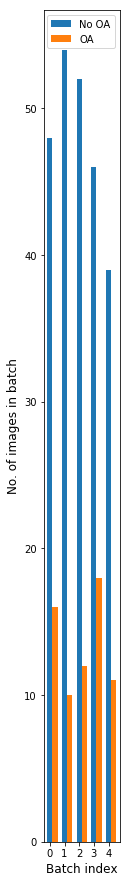

Avg Proportion of No OA per batch: 4.779999999999999
Avg Proportion of OA per batch: 1.3399999999999999
Num. unique images seen: 306/306


In [13]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


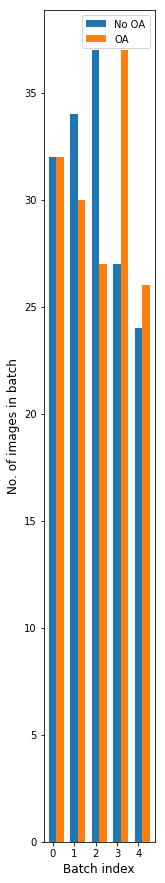

Avg Proportion of No OA per batch: 3.08
Avg Proportion of OA per batch: 3.04
Num. unique images seen: 306/306


In [14]:
train = CustomDataset(dataframe=train_data, transform=transform)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with normalized inputs, no oversampling

In [15]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 1, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 3, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 4, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 5, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 6, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 7, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 8, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 9, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 10, loss = nan

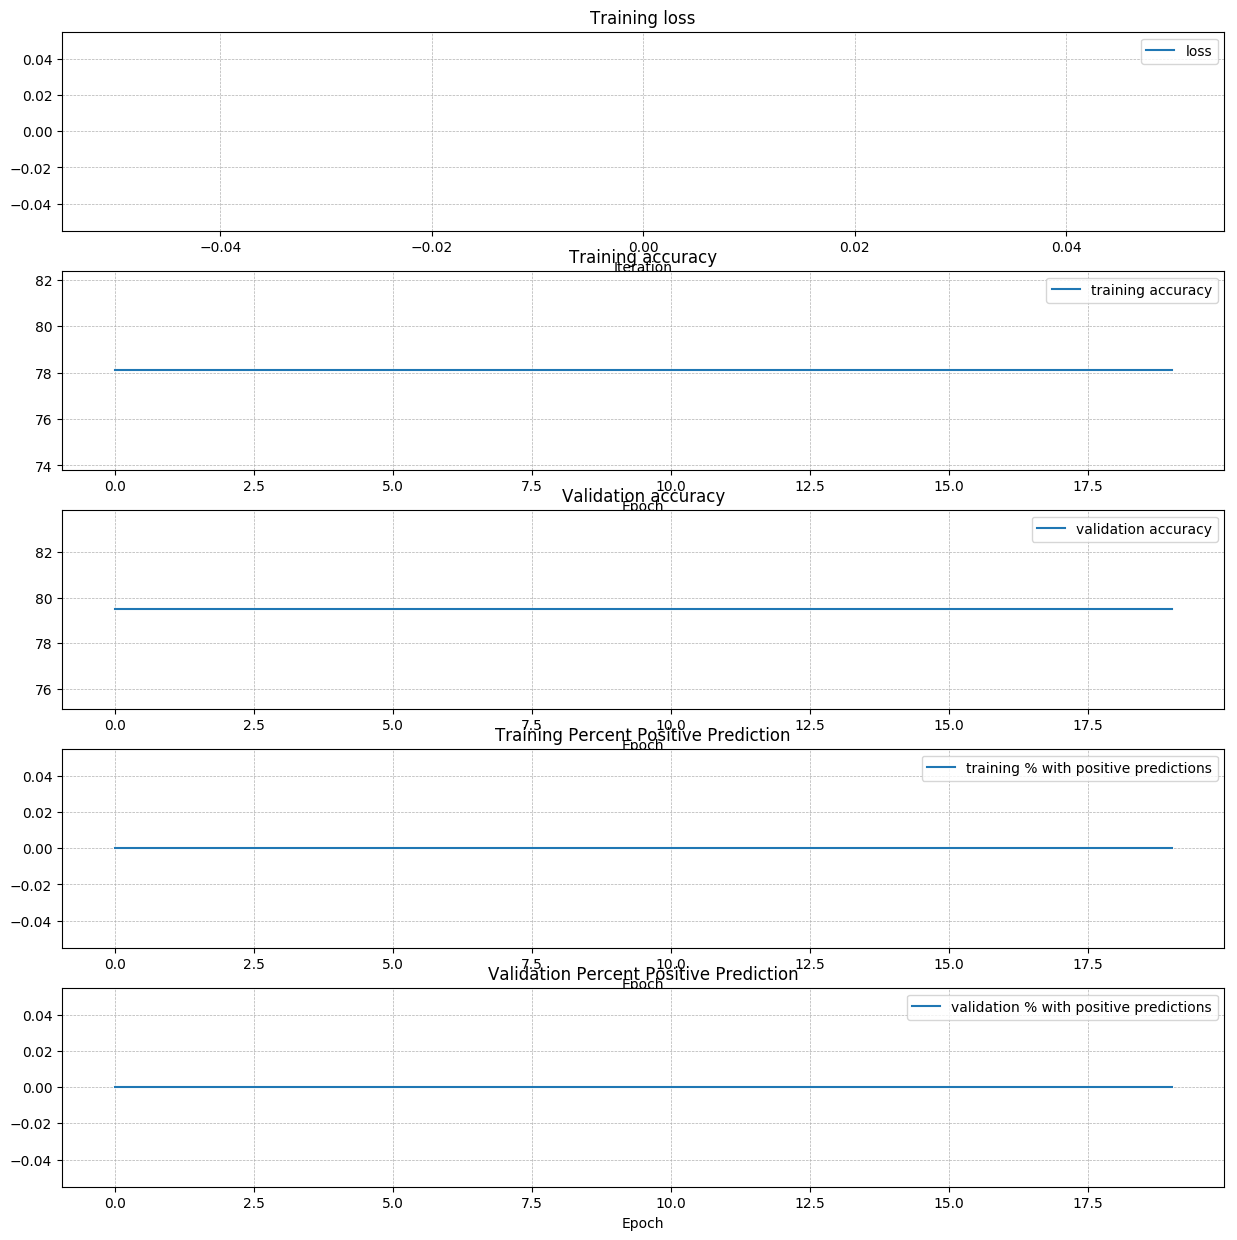

In [16]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs on oversampled training set

In [17]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, loss = nan, train_acc = 53.9216, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 1, loss = nan, train_acc = 50.3268, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = nan, train_acc = 47.7124, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 3, loss = nan, train_acc = 55.5556, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 4, loss = nan, train_acc = 48.0392, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 5, loss = nan, train_acc = 48.3660, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 6, loss = nan, train_acc = 48.6928, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 7, loss = nan, train_acc = 47.7124, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 8, loss = nan, train_acc = 48.3660, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 9, loss = nan, train_acc = 49.3464, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 10, loss = nan

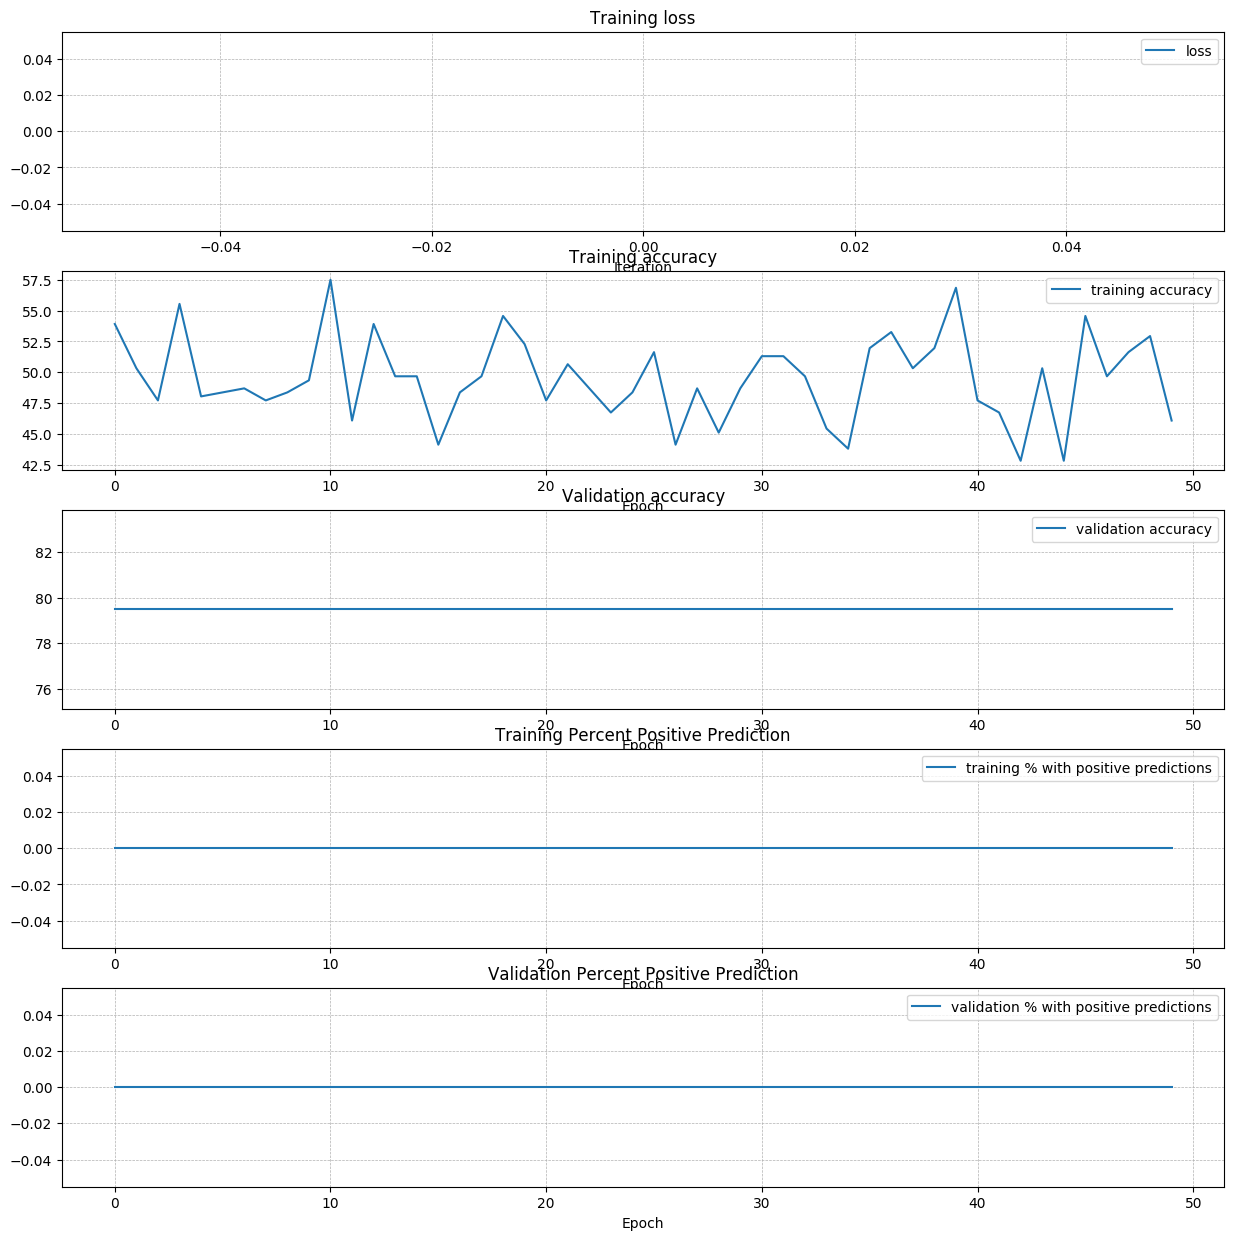

In [18]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs, alternative oversampling 

In [19]:
# oversample the train/val data by increasing number of OA=1 and increasing overall dataset size
#train_val_data = pd.concat([train_data, val_data], axis=0)
index_0 = train_data.index[train_data['OA_check'] == 0.0].tolist()
class_0 = train_data.loc[index_0]
index_1 = train_data.index[train_data['OA_check'] == 1.0].tolist()
class_1 = train_data.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_over = train_over.sample(frac = 1)

NUM_TRAIN_OS = len(train_over)

train = CustomDataset(dataframe=train_over, transform=transform)
loader_train_os2 = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_OS)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os2, loader_val, epochs=50)

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, loss = nan, train_acc = 50.0000, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 1, loss = nan, train_acc = 50.0000, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = nan, train_acc = 50.0000, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 3, loss = nan, train_acc = 50.0000, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 4, loss = nan, train_acc = 50.0000, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 5, loss = nan, train_acc = 50.0000, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 6, loss = nan, train_acc = 50.0000, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 7, loss = nan, train_acc = 50.0000, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 8, loss = nan, train_acc = 50.0000, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 9, loss = nan, train_acc = 50.0000, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 10, loss = nan

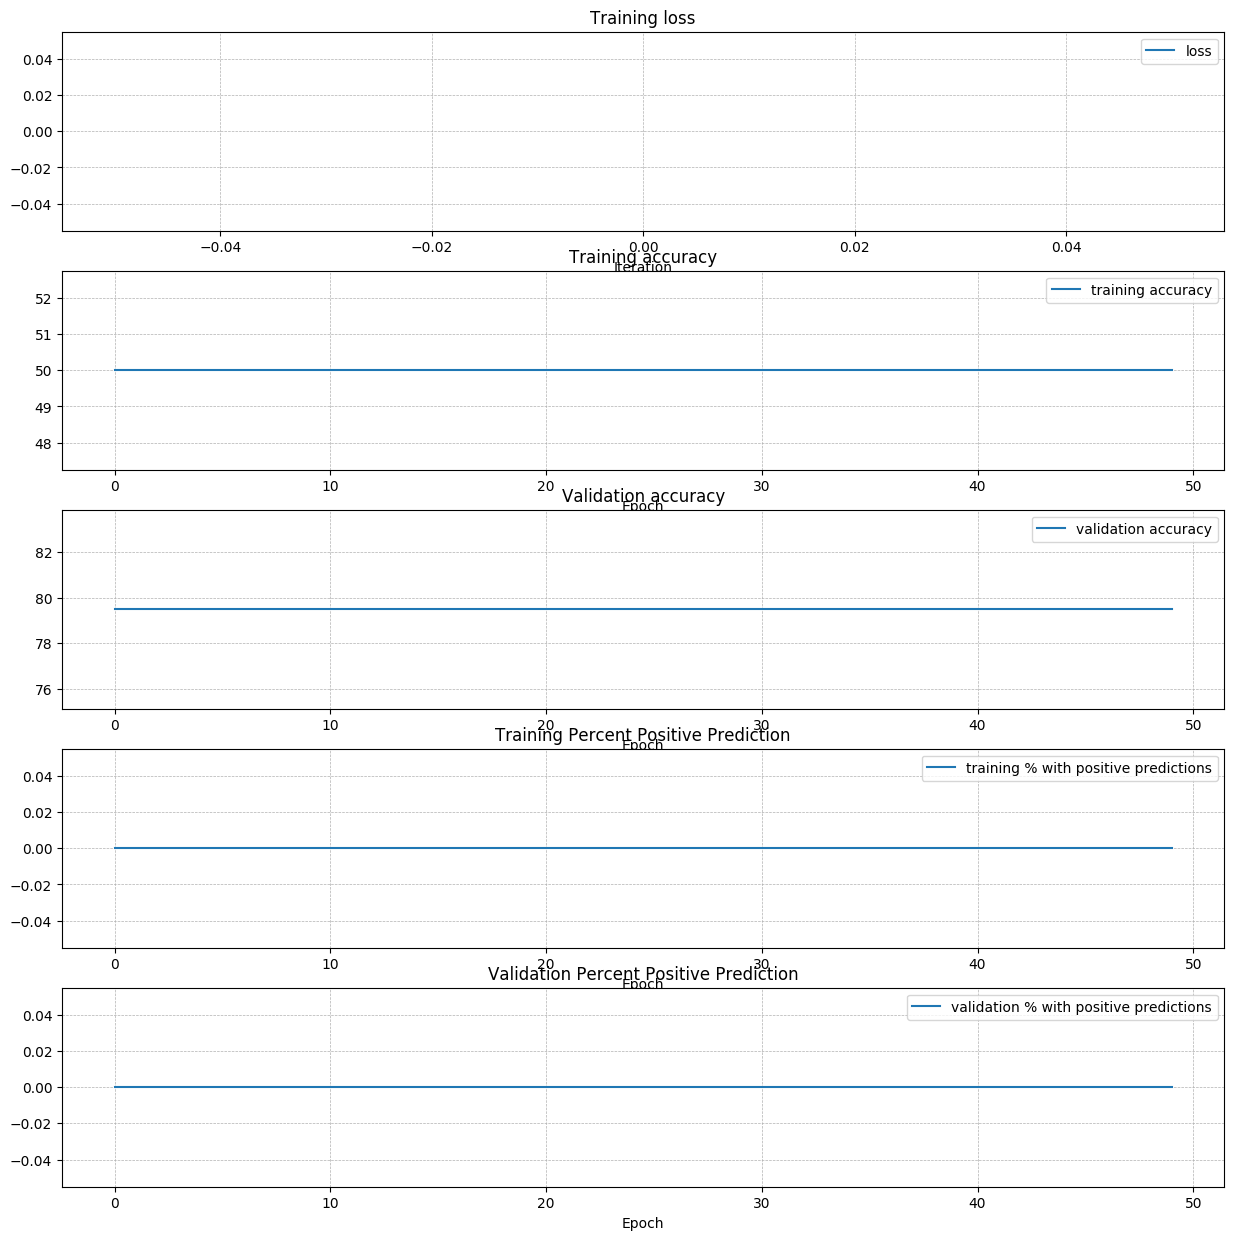

In [20]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling

In [21]:
train = CustomDataset(dataframe=train_data)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data)
loader_test = DataLoader(test, batch_size=64)

In [22]:
input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50)

Epoch 0, loss = 0.5701, train_acc = 78.1046, val_acc = 82.0513, train_pos = 1.9608, val_pos = 12.8205
Epoch 1, loss = 0.4892, train_acc = 79.4118, val_acc = 84.6154, train_pos = 9.8039, val_pos = 5.1282
Epoch 2, loss = 0.4931, train_acc = 80.0654, val_acc = 87.1795, train_pos = 7.1895, val_pos = 7.6923
Epoch 3, loss = 0.3207, train_acc = 80.0654, val_acc = 82.0513, train_pos = 6.5359, val_pos = 2.5641
Epoch 4, loss = 0.3885, train_acc = 80.3922, val_acc = 84.6154, train_pos = 2.9412, val_pos = 5.1282
Epoch 5, loss = 0.3982, train_acc = 81.3725, val_acc = 84.6154, train_pos = 3.9216, val_pos = 5.1282
Epoch 6, loss = 0.5138, train_acc = 80.3922, val_acc = 84.6154, train_pos = 2.9412, val_pos = 5.1282
Epoch 7, loss = 0.3085, train_acc = 83.3333, val_acc = 84.6154, train_pos = 7.1895, val_pos = 5.1282
Epoch 8, loss = 0.2560, train_acc = 82.0261, val_acc = 84.6154, train_pos = 4.5752, val_pos = 5.1282
Epoch 9, loss = 0.3802, train_acc = 82.3529, val_acc = 87.1795, train_pos = 4.9020, val_po

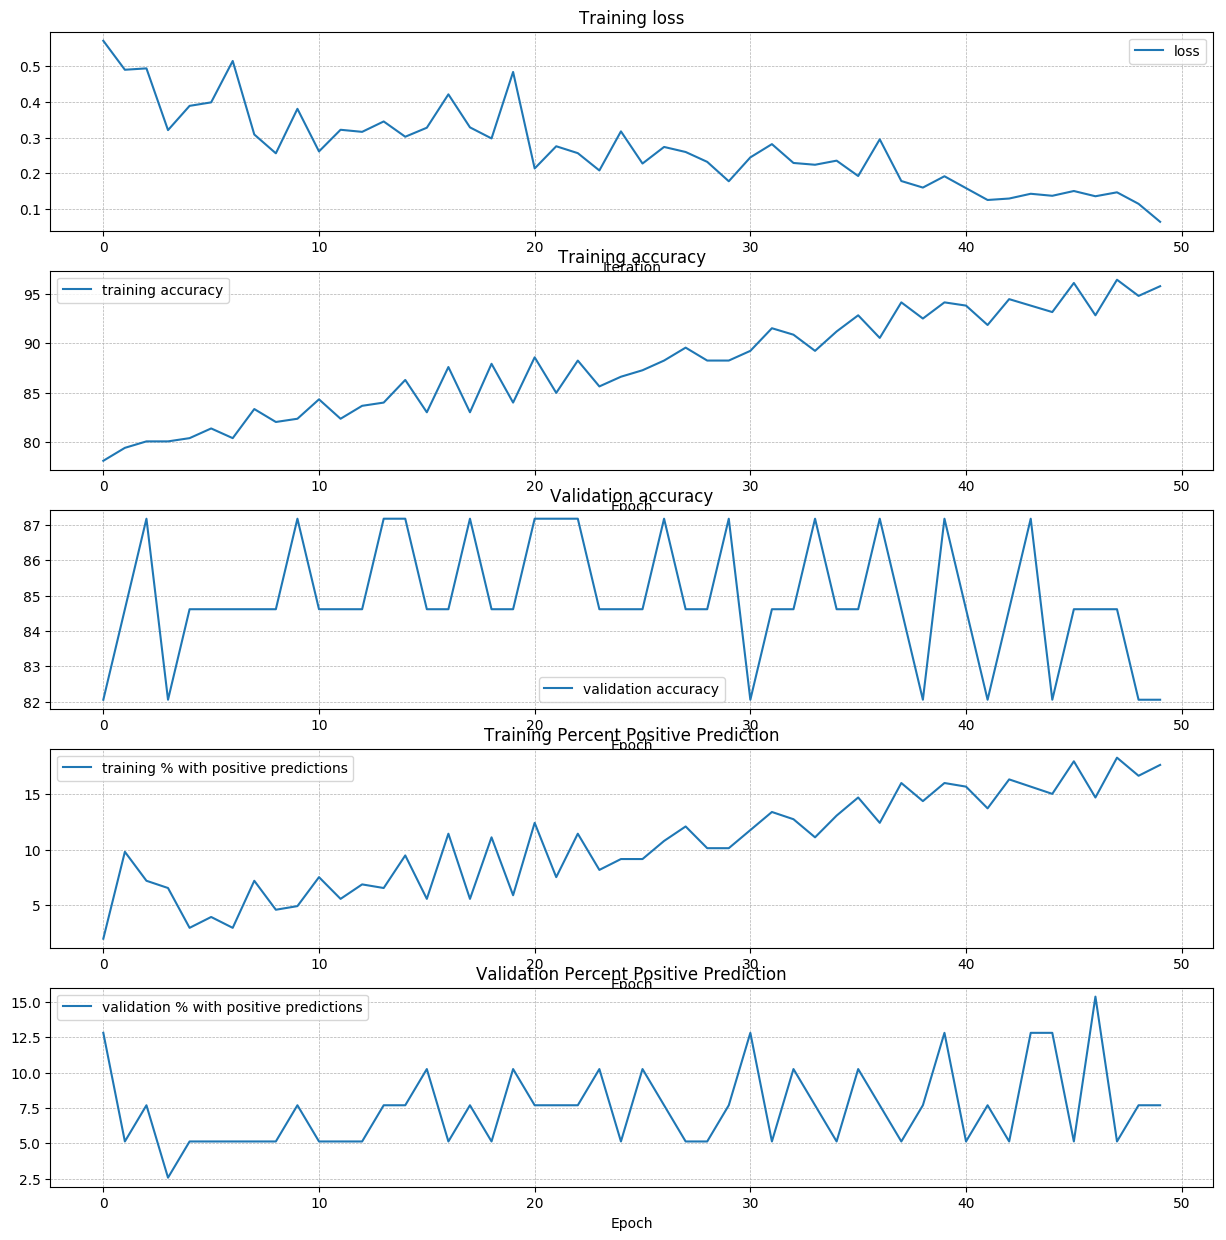

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling, weighted loss

In [24]:
# use weighted loss instead of oversampling 
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 2000
num_classes = 1

num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50, \
    use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

Epoch 0, loss = 1.2576, train_acc = 66.6667, val_acc = 76.9231, train_pos = 31.6993, val_pos = 12.8205
Epoch 1, loss = 1.0107, train_acc = 67.6471, val_acc = 87.1795, train_pos = 33.3333, val_pos = 17.9487
Epoch 2, loss = 0.9167, train_acc = 80.3922, val_acc = 76.9231, train_pos = 17.3203, val_pos = 33.3333
Epoch 3, loss = 1.1621, train_acc = 78.1046, val_acc = 84.6154, train_pos = 20.2614, val_pos = 15.3846
Epoch 4, loss = 0.6961, train_acc = 82.3529, val_acc = 79.4872, train_pos = 24.5098, val_pos = 20.5128
Epoch 5, loss = 1.0761, train_acc = 83.3333, val_acc = 71.7949, train_pos = 17.6471, val_pos = 33.3333
Epoch 6, loss = 0.7831, train_acc = 81.6993, val_acc = 82.0513, train_pos = 27.1242, val_pos = 12.8205
Epoch 7, loss = 0.6810, train_acc = 87.2549, val_acc = 71.7949, train_pos = 16.3399, val_pos = 33.3333
Epoch 8, loss = 0.5561, train_acc = 83.3333, val_acc = 84.6154, train_pos = 22.8758, val_pos = 15.3846
Epoch 9, loss = 0.7102, train_acc = 87.2549, val_acc = 71.7949, train_pos

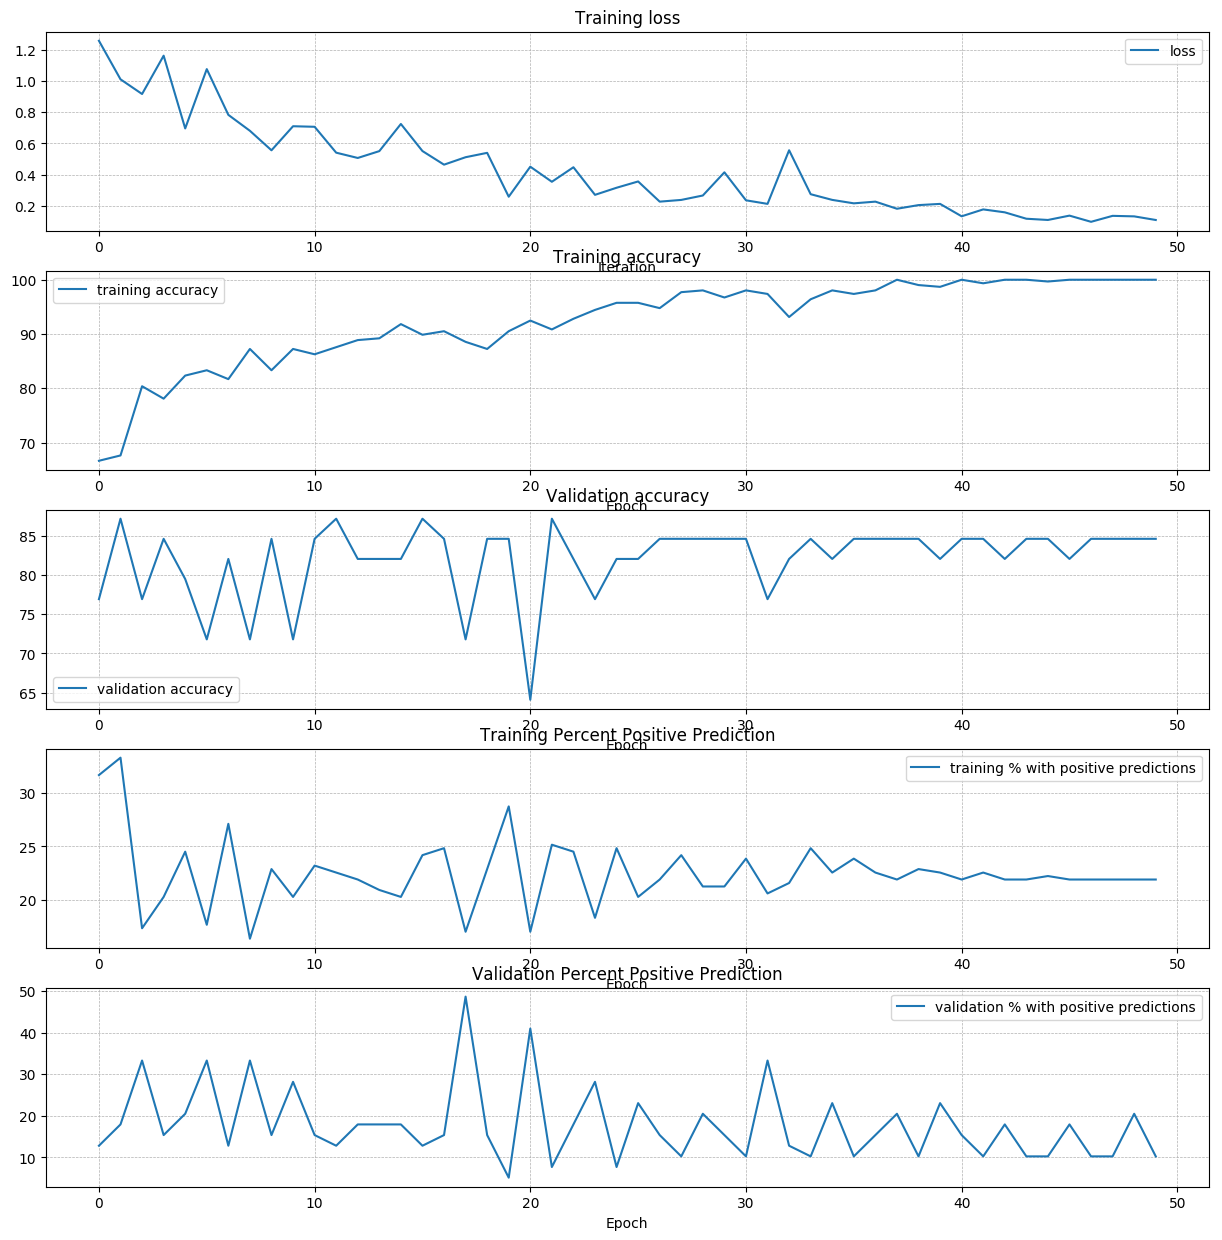

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()